In this notebook, we'll apply DSA to the setting of the Lorenz attractor, with different parameters governing the behavior. Zhang et al. (2025, ICML) used DSA on this setting with limited success, but we'll show here that it actually does work (and my pull request on their repo for an explanation). We'll also use this setting to illustrate the number of different ways GeneralizedDSA can be applied with different DMD operators. There's no control data here so we'll focus on standard DMD models

In [1]:
#default imports
import numpy as np
import torch
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#dsa imports
from DSA import DSA, GeneralizedDSA
from DSA import DMD
from DSA import DMDConfig
from DSA import SimilarityTransformDistConfig
from pydmd import DMD as pDMD
import DSA.pykoopman as pk

rng = np.random.default_rng(2023)

In [2]:
#lorenz63 class from Zhang et al code (thanks!)

class Lorenz63:
    """
    A dataset class for generating Lorenz system trajectories with different rho values.
    
    This class simulates the Lorenz system for multiple rho values and generates
    trajectory clips for each value.
    
    Attributes:
        rho_values (list): List of rho parameter values to simulate.
        initial_state (tuple): Initial state (x, y, z) for the Lorenz system.
        t_start (float): Start time for simulation.
        t_end (float): End time for simulation.
        dt (float): Time step for numerical integration.
        period_length (float): Length of each data clip in time units.
        num_clips (int): Number of clips to extract from each simulation.
        data (list): Generated trajectory data.
    """
    def __init__(self, rho_values, initial_state=(-8, 8, 27), t_start=0, t_end=800, 
                 dt=0.001, period_length=20, num_clips=25, random_seed=None):
        """
        Initialize the Lorenz dataset with specified parameters.
        
        Args:
            rho_values (list): List of rho parameter values to simulate.
            initial_state (tuple): Initial state (x, y, z) for the Lorenz system.
            t_start (float): Start time for simulation.
            t_end (float): End time for simulation.
            dt (float): Time step for numerical integration.
            period_length (float): Length of each data clip in time units.
            num_clips (int): Number of clips to extract from each simulation.
            random_seed (int, optional): Seed for random number generators.
        """
        if random_seed is not None:
            np.random.seed(random_seed)
            torch.manual_seed(random_seed)
        
        self.rho_values = rho_values
        self.initial_state = initial_state
        self.t_start = t_start
        self.t_end = t_end
        self.dt = dt
        self.period_length = period_length
        self.num_clips = num_clips
        self.data = self.generate_data()

    def lorenz(self, state, t, sigma=10, beta=8/3):
        """
        Lorenz system differential equations.
        
        Args:
            state (list): Current state [x, y, z].
            t (float): Current time (not used but required by odeint).
            sigma (float): Sigma parameter of the Lorenz system.
            beta (float): Beta parameter of the Lorenz system.
            
        Returns:
            list: Derivatives [dx/dt, dy/dt, dz/dt].
        """
        x, y, z = state
        dxdt = sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - beta * z
        return [dxdt, dydt, dzdt]

    def generate_data(self):
        """
        Generate trajectory data for all specified rho values.
        
        Returns:
            list: List of trajectory clips, each with shape (period_length/dt, 3).
        """
        data_list = []
        t_span = (self.t_start, self.t_end)
        t_eval = np.arange(self.t_start, self.t_end, self.dt)
        
        # Calculate the index for starting valid data (after transient period)
        valid_start_idx = int(300 / self.dt)
        
        # Store valid data for each rho value for later visualization
        self.valid_data_by_rho = {}

        for rho in self.rho_values:
            self.rho = rho
            
            # Define a wrapper function to fix the unpacking issue
            def lorenz_wrapper(t, state):
                return self.lorenz(state, t)
            
            # Solve the Lorenz system using solve_ivp
            solution = solve_ivp(
                lorenz_wrapper, 
                t_span, 
                self.initial_state, 
                method='RK45', 
                t_eval=t_eval
            )
            
            # Extract solution data
            solution_data = np.vstack([solution.y[0], solution.y[1], solution.y[2]]).T
            
            # Collect data after transient period
            valid_data = solution_data[valid_start_idx:]
            valid_length = len(valid_data)
            
            # Store the valid data for this rho value
            self.valid_data_by_rho[rho] = valid_data
            
            # Calculate clip size
            clip_size = int(self.period_length / self.dt)
            
            for k in range(self.num_clips):
                # Randomly select clips from the valid data
                max_start_index = valid_length - clip_size
                if max_start_index > 0:
                    start_index = np.random.randint(0, max_start_index)
                    end_index = start_index + clip_size
                    period_data = valid_data[start_index:end_index]
                    data_list.append(period_data)
        
        return data_list
    
    def visualize_data(self, time_range=None):
        """
        Visualize the generated data with trajectories colored by rho values.
        
        Creates a 3D plot for each rho value showing the Lorenz attractor trajectories.
        
        Parameters:
        -----------
        time_range : tuple, optional
            A tuple of (start_time, end_time) to plot only a specific time range of the trajectories.
            If None, the entire trajectory is plotted.
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D
        
        # Determine number of unique rho values
        n_rho = len(self.rho_values)
        
        # Create figure with subplots
        fig = plt.figure(figsize=(4*n_rho, 4))
        
        # Create a subplot for each rho value
        for i, rho in enumerate(self.rho_values):
            ax = fig.add_subplot(1, n_rho, i+1, projection='3d')
            ax.set_title(f'ρ = {rho}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            
            # Get the valid data for this rho value
            valid_data = self.valid_data_by_rho[rho]
            
            # Apply time range selection if specified
            if time_range is not None:
                start_idx = int((time_range[0] - 300) / self.dt)  # Adjust for transient period
                end_idx = int((time_range[1] - 300) / self.dt)
                # Ensure indices are within bounds
                start_idx = max(0, start_idx)
                end_idx = min(len(valid_data), end_idx)
                plot_data = valid_data[start_idx:end_idx]
            else:
                plot_data = valid_data
            
            # Plot the trajectory
            ax.plot(plot_data[:, 0], plot_data[:, 1], plot_data[:, 2], linewidth=0.8)
        
        plt.tight_layout()
        plt.show()


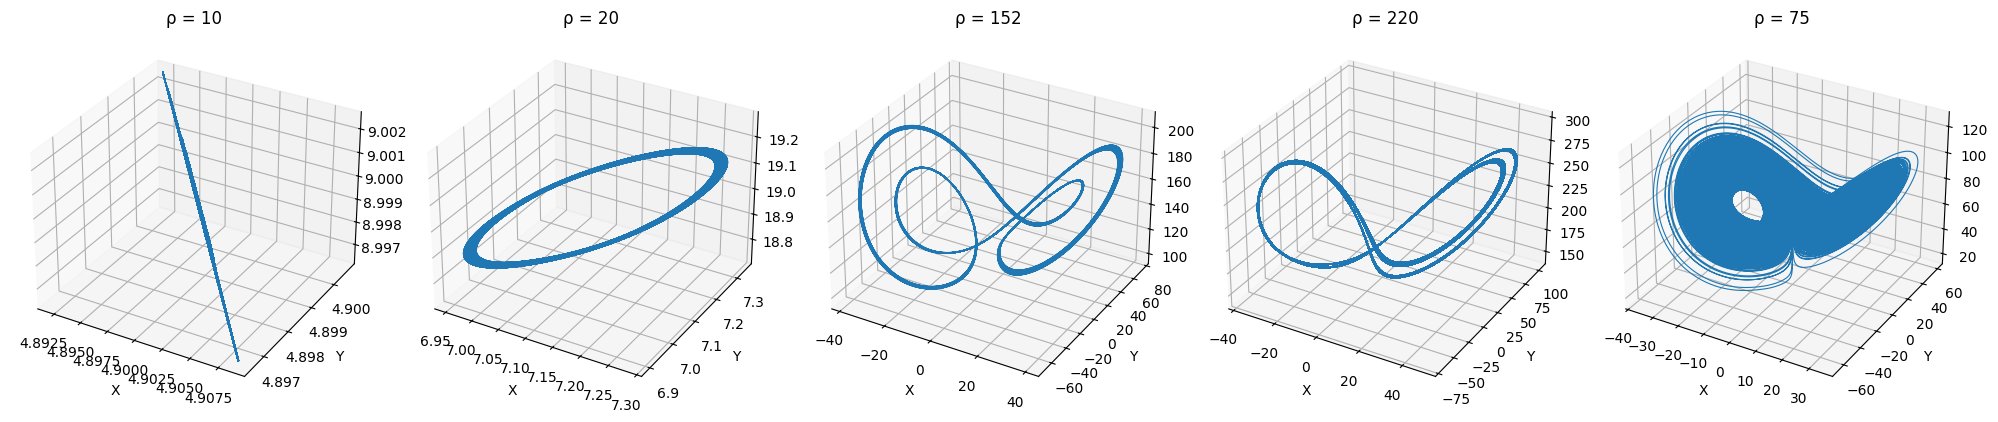

In [3]:
num_clips = 20
rho_values = [10, 20, 152, 220, 75]# Add labels for different rho values (5 rho values, 40 clips each)
rho_labels = []
for rho in rho_values:
    rho_labels.extend([f"ρ={rho}"] * num_clips)  # 40 clips per rho value

lorenz = Lorenz63(rho_values=rho_values, num_clips=num_clips,period_length=20,random_seed=2023)
# fig, ax = plt.subplots()
lorenz.visualize_data(time_range=None)

A key step in this dataset is to preprocess by whitening the data and subsampling it to take larger timesteps. This ensures that the dynamics can be aptly captured by the DMD. Here we'll subsample by a factor of 10 (i.e. only skipping 10 steps to fit our models to). This allows the system to capture longer timescales (more relevant to comparison) with greater computational efficiency. We could similarly take 10 times as many delays, but that would make fitting slower.  

In [4]:
from sklearn.preprocessing import StandardScaler

subsample = 10

data = lorenz.data 
ss = StandardScaler()
data = [ss.fit_transform(i) for i in data]
data = [i[::subsample] for i in data]
data[0].shape, len(data)

((2000, 3), 100)

In [5]:
from DSA import DSA
# #compute silhouette score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

dsa = DSA(data,verbose=True, n_delays=70,rank=6,score_method='wasserstein')
sims = dsa.fit_score()


Fitting DMDs: 100%|██████████| 100/100 [00:01<00:00, 57.16it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 4950/4950 [00:01<00:00, 3277.61it/s]


/Users/mitchellostrow/Desktop/Projects/dsa_test/DSA/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


5 [0. 1. 1. 1. 1.]


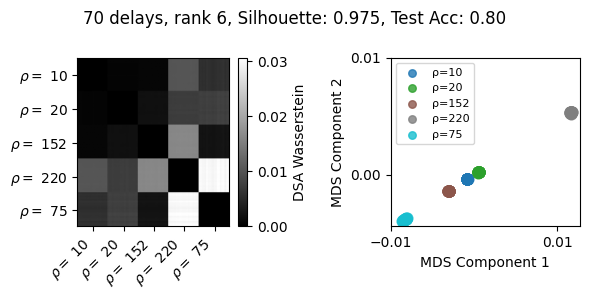

In [7]:

from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(6,3))  # Add a third axis for decoding accuracy

# Plot heatmap
im = axes[0].imshow(sims, cmap='gist_gray', aspect='auto')
cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label('DSA Wasserstein')
rho_values = [10, 20, 152, 220, 75]

lorenz_names = [rf"$\rho=$ {rho_values[i]}" for i in range(len(rho_values))]
tick_positions = [num_clips/2 + i*num_clips for i in range(5)]
axes[0].set_xticks(tick_positions)
axes[0].set_yticks(tick_positions)
axes[0].set_xticklabels(lorenz_names, rotation=45, ha='right')
axes[0].set_yticklabels(lorenz_names, rotation=0)

# Perform MDS for visualization
vis = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = vis.fit_transform(sims)

# Create data for scatter plot
x = embedding[:, 0]
y = embedding[:, 1]
silhouette_score_ = round(silhouette_score(sims, rho_labels),3)

# Plot scatter with improved styling
# Create a color map for each unique rho value
unique_labels = []
for label in rho_labels:
    if label not in unique_labels:
        unique_labels.append(label)

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

for label in unique_labels:
    mask = [rho_labels[i] == label for i in range(len(rho_labels))]
    axes[1].scatter(x[mask], y[mask], label=label, s=60, alpha=0.8, color=label_to_color[label])

axes[1].set_xlabel('MDS Component 1')
axes[1].set_ylabel('MDS Component 2')
axes[1].set_xticks([round(min(x),2), round(max(x),2)])
axes[1].set_yticks([round(min(y),2), round(max(y),2)])
axes[1].legend(frameon=True, fontsize=8, markerscale=0.7)

def compute_decoding_accuracy(sims, rho_labels, n_splits=5, random_state=42):
    """
    Computes the decoding accuracy using a linear classifier with stratified k-fold cross-validation.

    Parameters:
    - sims: The similarity matrix used as features for classification.
    - rho_labels: The labels corresponding to each sample in the similarity matrix.
    - n_splits: Number of splits for stratified k-fold cross-validation.
    - random_state: Random state for reproducibility.

    Returns:
    - avg_test_acc: Average test accuracy over all folds.
    - avg_per_class_acc: Average per-class accuracy over all folds.
    """
    # Encode string labels to integers for classification
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(rho_labels)

    # Initialize stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize variables to store results
    test_accs = []
    per_class_accs = []

    # Perform stratified k-fold cross-validation
    for train_index, test_index in skf.split(sims, y_encoded):
        X_train, X_test = sims[train_index], sims[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Train the classifier
        clf = LinearSVC(max_iter=10000,C=10)
        clf.fit(X_train, y_train)

        # Predict on the test set
        y_pred = clf.predict(X_test)

        # Compute test accuracy
        test_acc = accuracy_score(y_test, y_pred)
        test_accs.append(test_acc)

        # Compute per-class accuracy
        per_class_acc = []
        class_names = np.unique(y_encoded)
        for i, class_label in enumerate(class_names):
            idx = (y_test == i)
            acc = accuracy_score(y_test[idx], y_pred[idx])
            per_class_acc.append(acc)
        per_class_accs.append(per_class_acc)

    # Average test accuracy and per-class accuracy over all folds
    avg_test_acc = np.mean(test_accs)
    avg_per_class_acc = np.mean(per_class_accs, axis=0)

    return avg_test_acc, avg_per_class_acc

# Example usage:
avg_test_acc, avg_per_class_acc = compute_decoding_accuracy(sims, rho_labels)

# Plot per-class decoding accuracy
print(len(avg_per_class_acc),avg_per_class_acc)
# axes[2].bar(range(len(rho_values)), avg_per_class_acc, color='gray')  # Ensure 5 bars are plotted
# axes[2].set_xticks(range(len(rho_values)))
# axes[2].set_xticklabels(rho_values, rotation=45, ha='right')
# axes[2].set_ylim(0, 1.05)
# axes[2].set_xlim(-1, len(rho_values))
# axes[2].set_ylabel('Test Accuracy')
# for i, acc in enumerate(avg_per_class_acc):
    # axes[2].text(i, acc+0.02, f"{acc:.2f}", ha='center', va='bottom', fontsize=8)
# axes[2].text(0.5, 0.95, f"Avg Test Acc: {avg_test_acc:.2f}", ha='center', va='top', fontsize=10, transform=axes[2].transAxes)

plt.suptitle(f"{dsa.n_delays[0][0]} delays, rank {dsa.rank[0][0]}, Silhouette: {silhouette_score_}, Test Acc: {avg_test_acc:.2f}")

plt.tight_layout()
# plt.savefig(f"{save_path}/dsa_silhouette_clustering_{dsa.n_delays[0][0]}nd_r{dsa.rank[0][0]}.pdf", dpi=300)
# plt.show()